In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
learning_rate = 0.001
epochs = 20
batch_size = 64

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = './data', 
                                        train = True, 
                                        download = True, 
                                        transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = batch_size, 
                                          shuffle = True)

testset = torchvision.datasets.CIFAR10(root = './data', 
                                       train = False, 
                                       download = True, 
                                       transform = transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(f'Размер тренировочной выборки изображений: {trainloader.dataset.data.shape}')
print(f'Размер тренировочной выборки меток: ({len(trainloader.dataset.targets)})')
print(f'Размер тестовой выборки изображений: {testloader.dataset.data.shape}')
print(f'Размер тестовой выборки меток: ({len(testloader.dataset.targets)})')

print('GPU or CPU:', device)

Размер тренировочной выборки изображений: (50000, 32, 32, 3)
Размер тренировочной выборки меток: (50000)
Размер тестовой выборки изображений: (10000, 32, 32, 3)
Размер тестовой выборки меток: (10000)
GPU or CPU: cuda


In [5]:
def plot_cifar10(X):
    fig, axes = plt.subplots(10, 10, figsize=(14, 14))
    
    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            axes[i, j].imshow(X.dataset.data[index], 
                              cmap=plt.cm.binary)
            axes[i, j].axis('off')
            axes[i, j].set_title(X.dataset.classes[X.dataset.targets[index]])
    plt.tight_layout()
    plt.show()

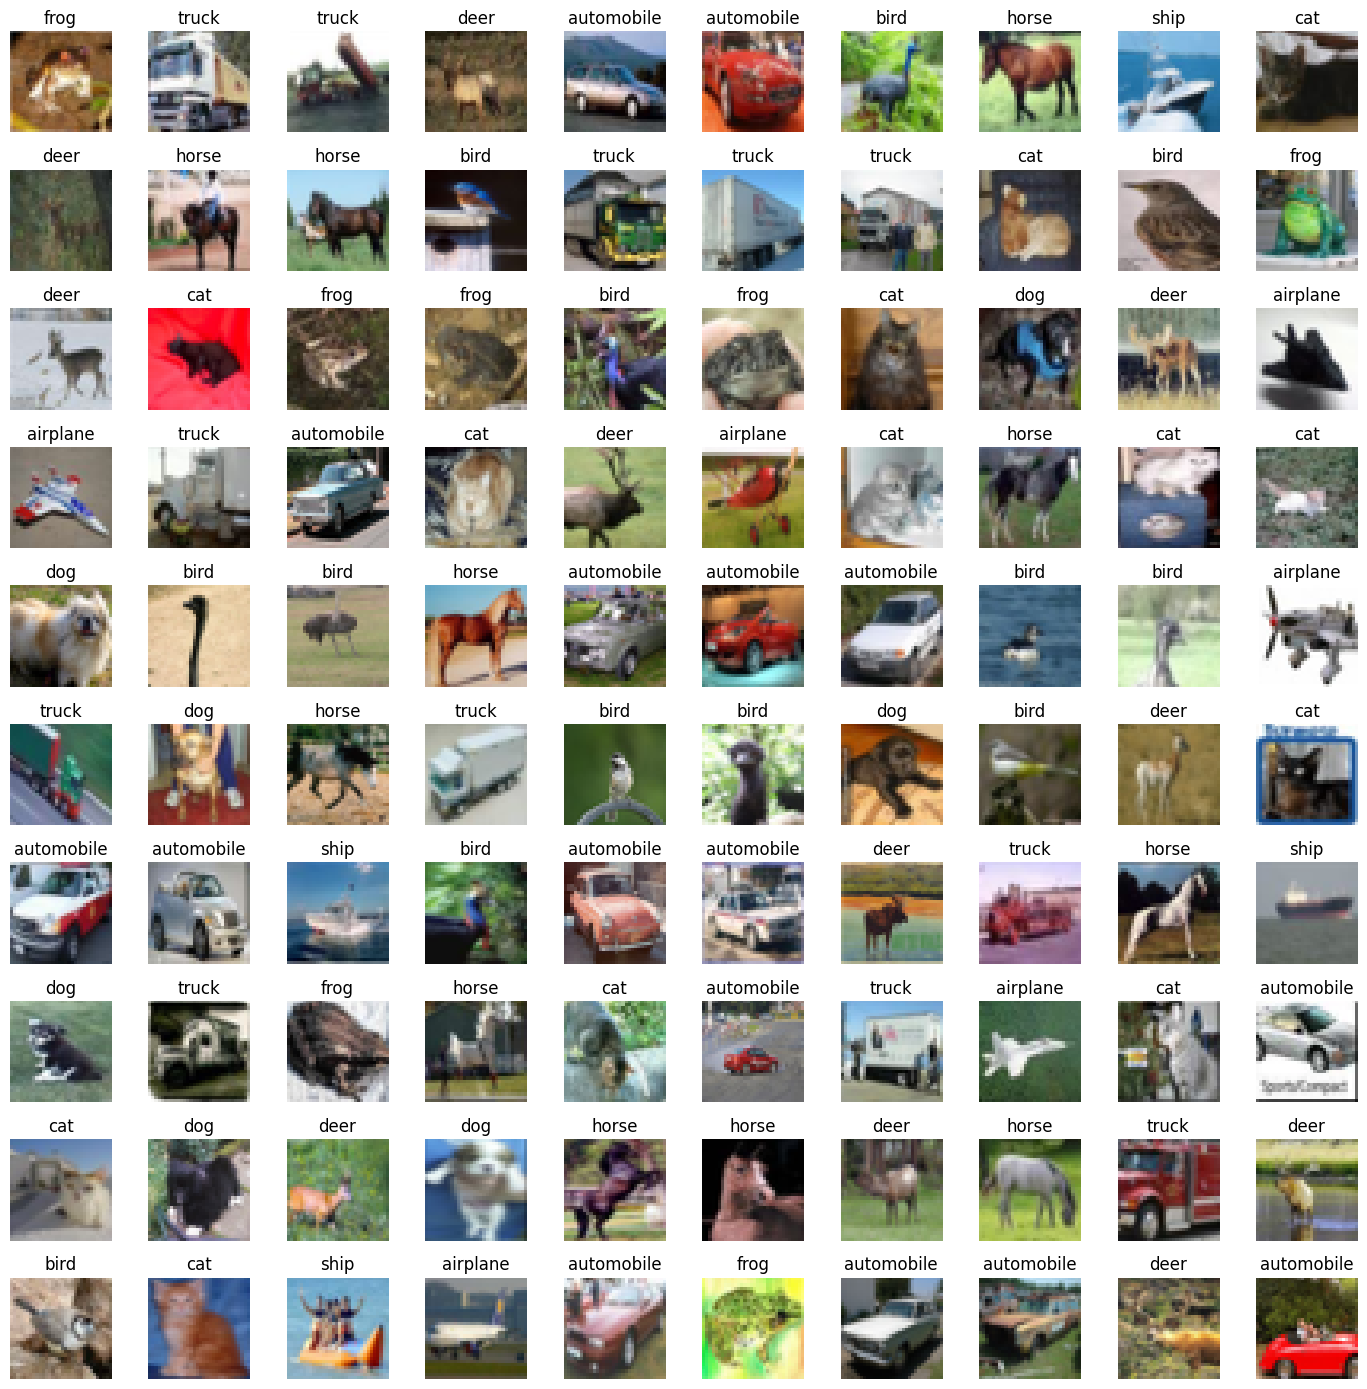

In [6]:
plot_cifar10(trainloader)

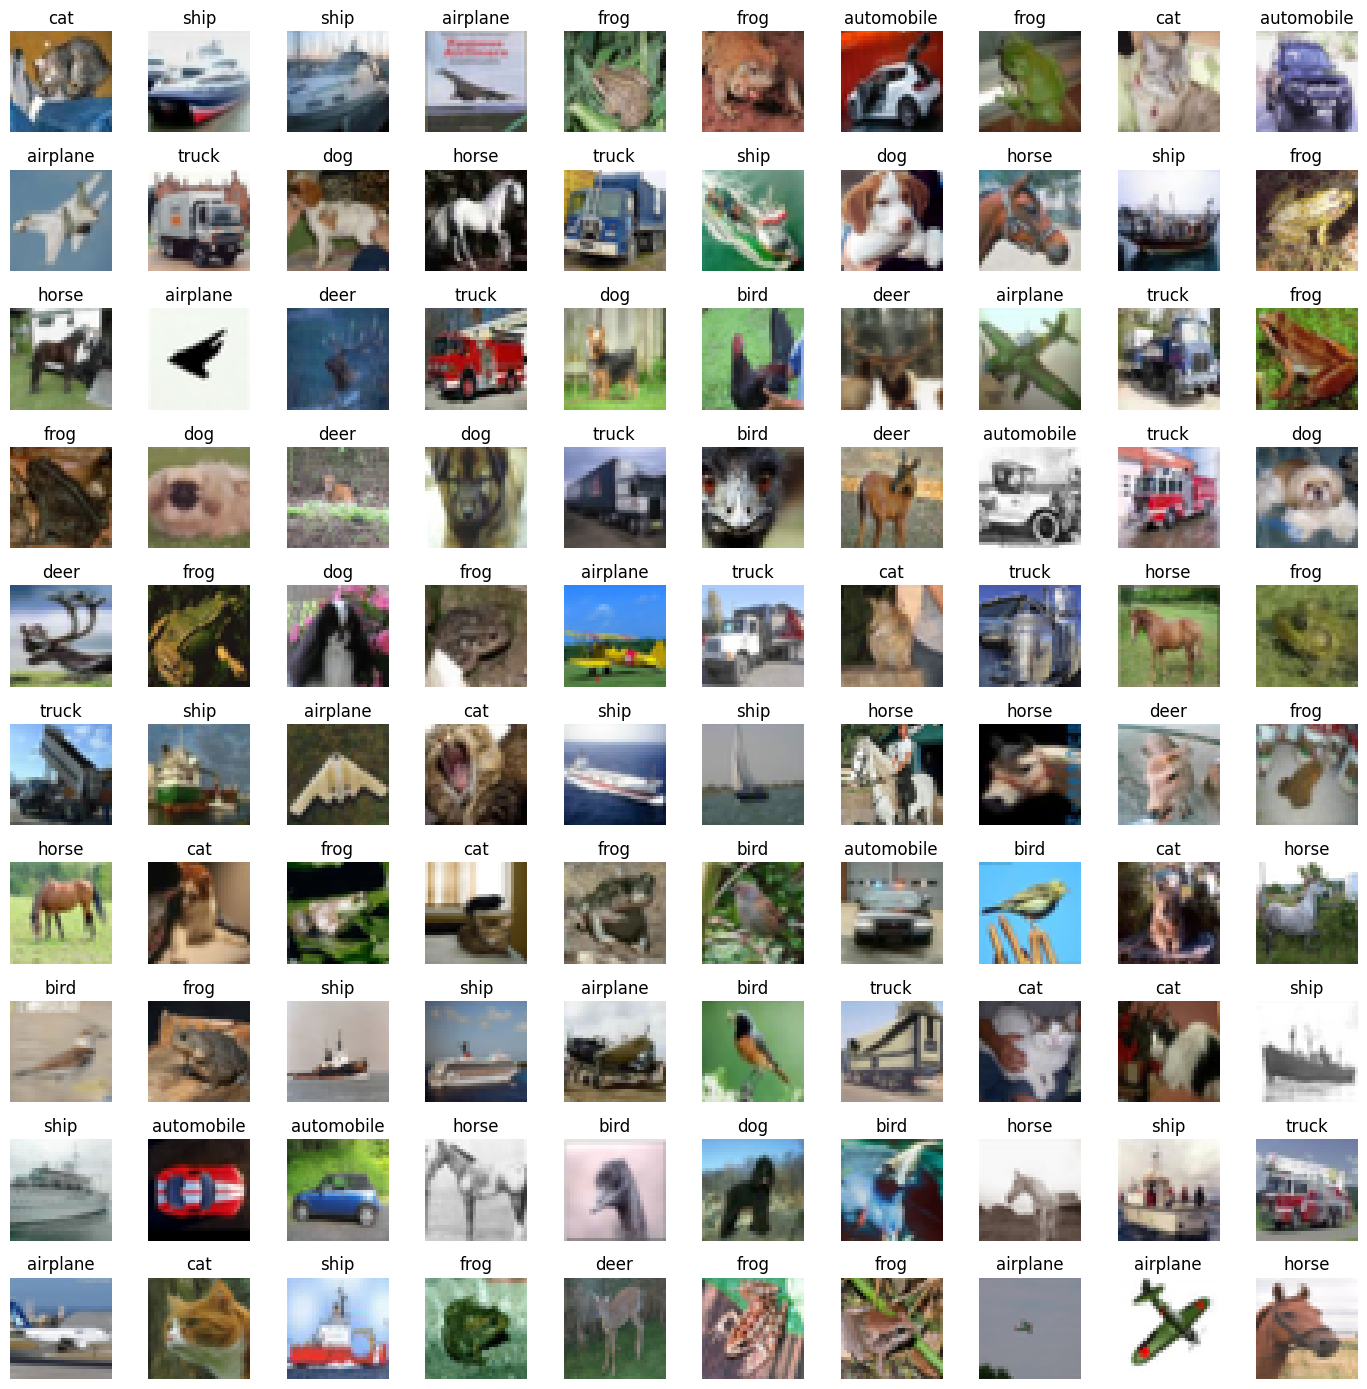

In [7]:
plot_cifar10(testloader)

In [8]:
def conv_block(input_channels, output_channels, pool):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(output_channels),
              nn.ReLU()]

    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class NeuralNetwork(nn.Module):
    def __init__(self, input_channels = 3, output_channels = 10):
        super().__init__()
        self.block1 = nn.Sequential(conv_block(input_channels, 64, False),
                                    conv_block(64, 64, False),
                                    conv_block(64, 128, True),
                                    conv_block(128, 128, False),
                                    conv_block(128, 256, True),
                                    conv_block(256, 256, False),
                                    conv_block(256, 512, True),
                                    conv_block(512, 512, False)
        )

        self.block2 = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, output_channels))

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out

In [9]:
net = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
summary(net, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Sequential: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-3                   [-1, 128, 16, 16]         --
|    |    └─Conv2d: 3-7                  [-1, 128, 32, 32]         73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 32, 32]         256
|    |    └─ReLU: 3-9                    [-1, 128, 32, 32]         --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Sequential: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-3                   [-1, 128, 16, 16]         --
|    |    └─Conv2d: 3-7                  [-1, 128, 32, 32]         73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 32, 32]         256
|    |    └─ReLU: 3-9                    [-1, 128, 32, 32]         --
|

In [10]:
graph_loss = []
graph_acc = []
for epoch in range(epochs):
    accuracy_list = []
    loss_list = []
    time_one = time.time()
    for data in trainloader:
        images = data[0].to(device)
        labels = data[1].to(device)
    
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        accuracy_list.append(torch.mean(torch.argmax(outputs, dim = 1) == labels, dtype = float))

    diff_time = time.time() - time_one
    print(f"Epoch: {epoch + 1}/{epochs}, "
          f"Loss: {torch.stack(loss_list).mean():.4f}, "
          f"Train accuracy: {torch.stack(accuracy_list).mean():.4f}, "
          f"Time: {diff_time:.2f} ")
    graph_loss.append(torch.stack(loss_list).mean().cpu().detach().numpy())
    graph_acc.append(torch.stack(accuracy_list).mean().cpu().detach().numpy())

Epoch: 1/20, Loss: 1.1297, Train accuracy: 0.5941, Time: 34.50 
Epoch: 2/20, Loss: 0.6678, Train accuracy: 0.7671, Time: 34.28 
Epoch: 3/20, Loss: 0.5086, Train accuracy: 0.8241, Time: 34.27 
Epoch: 4/20, Loss: 0.4046, Train accuracy: 0.8595, Time: 33.98 
Epoch: 5/20, Loss: 0.3147, Train accuracy: 0.8898, Time: 34.02 
Epoch: 6/20, Loss: 0.2470, Train accuracy: 0.9130, Time: 33.52 
Epoch: 7/20, Loss: 0.1782, Train accuracy: 0.9377, Time: 33.74 
Epoch: 8/20, Loss: 0.1379, Train accuracy: 0.9521, Time: 34.51 
Epoch: 9/20, Loss: 0.1057, Train accuracy: 0.9627, Time: 34.52 
Epoch: 10/20, Loss: 0.0827, Train accuracy: 0.9711, Time: 34.48 
Epoch: 11/20, Loss: 0.0741, Train accuracy: 0.9736, Time: 34.52 
Epoch: 12/20, Loss: 0.0634, Train accuracy: 0.9780, Time: 34.63 
Epoch: 13/20, Loss: 0.0537, Train accuracy: 0.9808, Time: 34.58 
Epoch: 14/20, Loss: 0.0487, Train accuracy: 0.9834, Time: 34.57 
Epoch: 15/20, Loss: 0.0455, Train accuracy: 0.9841, Time: 34.61 
Epoch: 16/20, Loss: 0.0442, Train 

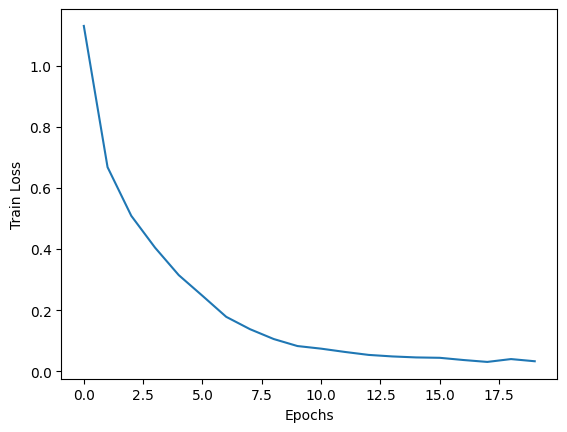

In [11]:
plt.plot(graph_loss)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

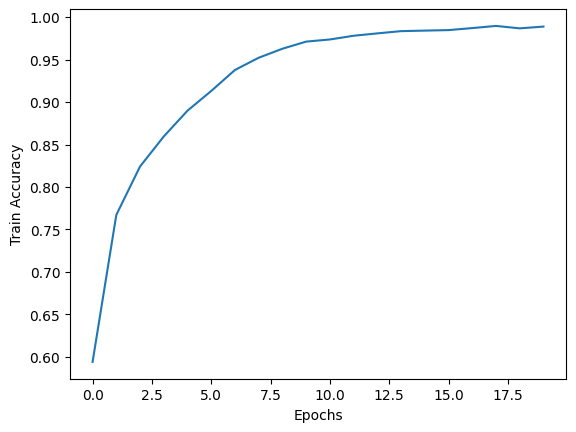

In [12]:
plt.plot(graph_acc)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.show()

In [13]:
def test_loss_acc(X):
    loss = 0
    acc = 0
    n = 0
    with torch.no_grad():
        for data in X:
            images = data[0].to(device)
            labels = data[1].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels)
            n += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            acc += (predicted == labels).sum()
    print(f"Test loss: {loss / n:.4f}, Test accuracy: {acc / n:.4f}")   

test_loss_acc(testloader)

Test loss: 0.0099, Test accuracy: 0.8757


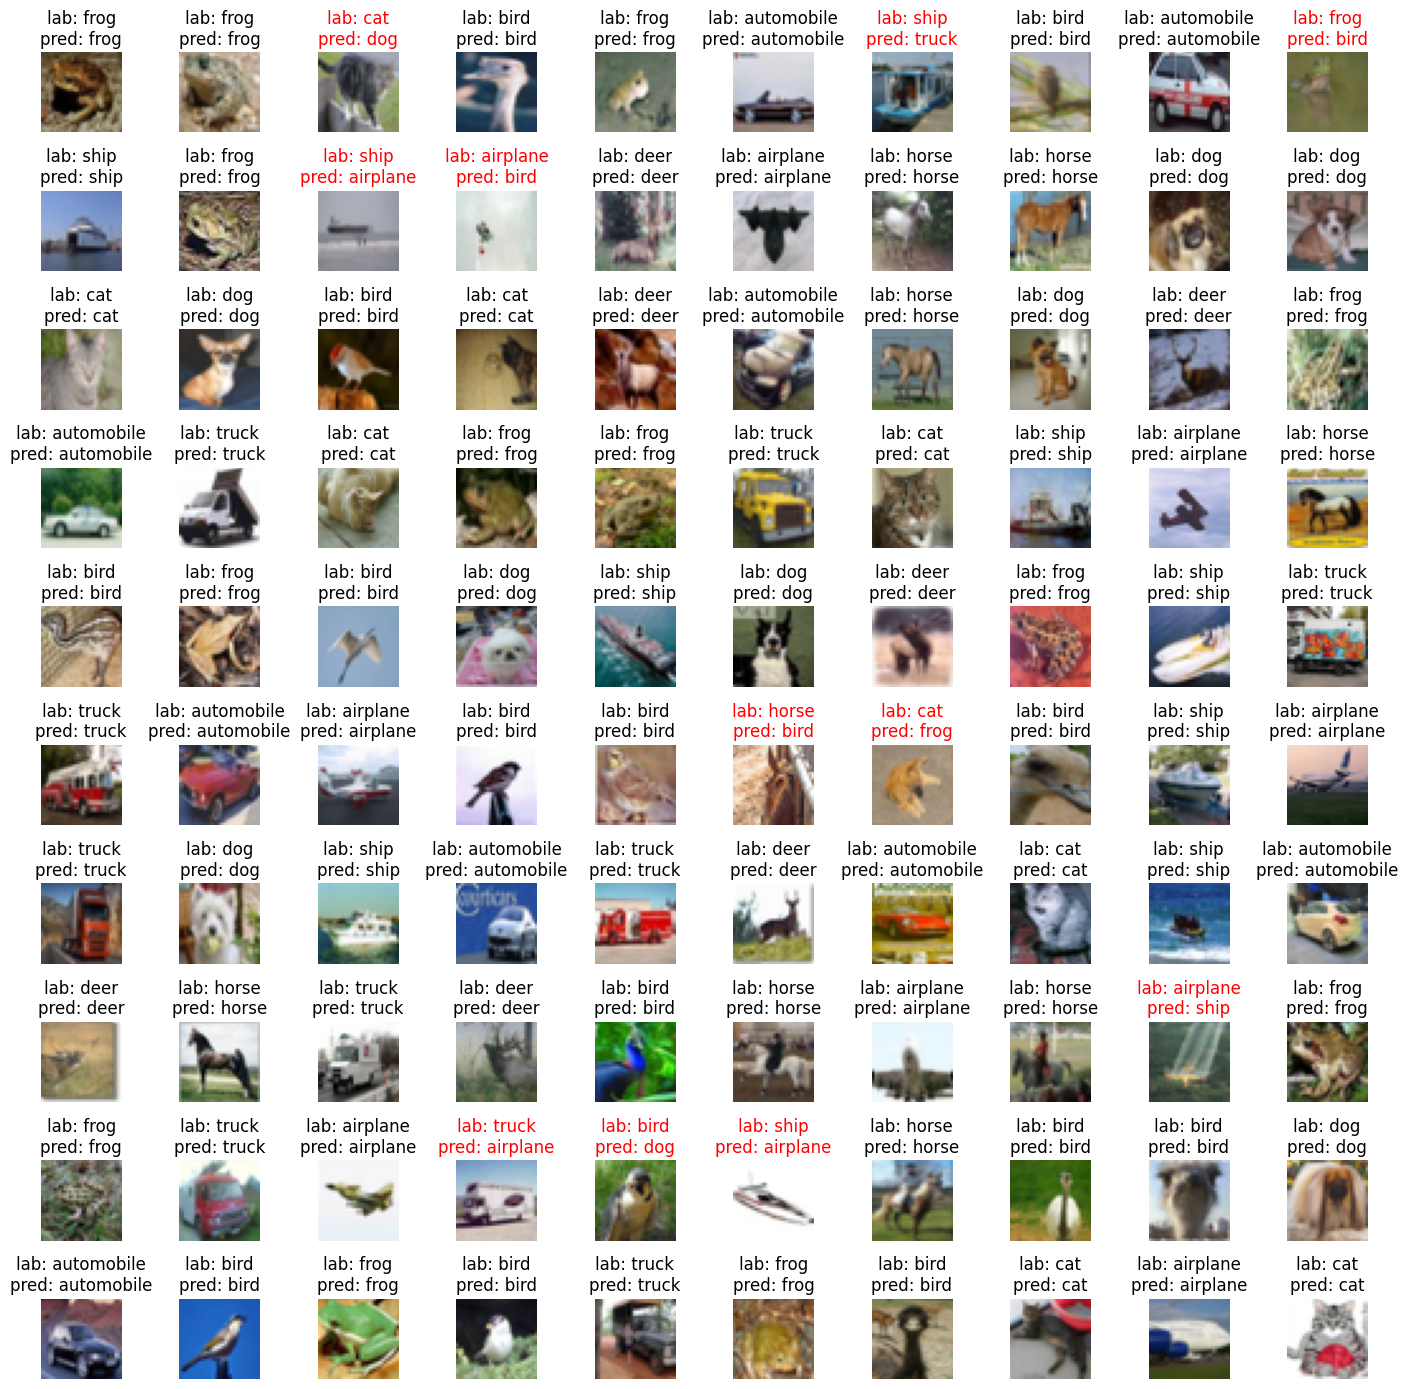

In [16]:
def plot_test(X):
    fig, axes = plt.subplots(10, 10, figsize=(14, 14))
    with torch.no_grad():
        for data in X:
            p = torch.rand([1])
            images = data[0].to(device)
            labels = data[1]
            predict = torch.argmax(net(images), dim = 1)
            if p >= 0.7:
                break

    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            img = images[index].cpu()*torch.tensor((0.5, 0.5, 0.5)).reshape(3, 1, 1) + \
                                      torch.tensor((0.5, 0.5, 0.5)).reshape(3, 1, 1)
            img = img.numpy().transpose(1, 2, 0)
            axes[i, j].imshow((img * 255).astype(numpy.uint8), cmap=plt.cm.binary)
            axes[i, j].axis('off')
            lab = X.dataset.classes[labels[index].item()]
            pred = X.dataset.classes[predict[index]]
            labels_str = 'lab: ' + lab + '\n' + 'pred: ' + pred
            if lab == pred:
                axes[i, j].set_title(labels_str)
            else:
                axes[i, j].set_title(labels_str, color = 'red')
    plt.tight_layout()
    plt.show()

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = 100, 
                                         shuffle = False)
plot_test(testloader)